In [40]:
from scipy import signal
import matplotlib.pyplot as plt
from imageio import imread
import numpy as np
import os

In [41]:
# adaptive weighted-edge linear interpolation
# grbg format

def Reflective_Padding(img):
    """
    Reflective padding for 3*3 kernel convolution
    """
    length = img.shape[0]
    width = img.shape[1]
    padded_length = length + 2
    padded_width = width + 2
    
    padded_img = np.zeros((padded_length, padded_width))
    padded_img[1:padded_length-1, 1:padded_width-1] = img
    padded_img[0, 1:padded_width-1] = padded_img[2, 1:padded_width-1]
    padded_img[padded_length-1, 1:padded_width-1] = padded_img[padded_length-3, 1:padded_width-1]
    padded_img[:, 0] = padded_img[:, 2]
    padded_img[:, padded_width-1] = padded_img[:, padded_width-3]
    
    return padded_img
    

def Local_Gradients(padded_img):
    """
    Calculate local gradients in 4 directions.
    """
    padded_length = padded_img.shape[0]
    padded_width = padded_img.shape[1]
    
    # gradient matrices
    x_grad = np.zeros((padded_length, padded_width)) # horizontal direction
    y_grad = np.zeros((padded_length, padded_width)) # vertical direction
    d_grad = np.zeros((padded_length, padded_width)) # main diagonal direction
    a_grad = np.zeros((padded_length, padded_width)) # anti-diagonal direction
    
    # calculate internal elements
    for i in range(1, padded_length-1):
        for j in range(1, padded_width-1):
            x_grad[i][j] = (padded_img[i][j+1] - padded_img[i][j-1]) / 2
            y_grad[i][j] = (padded_img[i-1][j] - padded_img[i+1][j]) / 2
            if (i + j) % 2 == 0: # at G locations
                d_grad[i][j] = max(
                    abs(padded_img[i-1][j-1]-padded_img[i][j]), abs(padded_img[i+1][j+1]-padded_img[i][j])
                ) / (2**0.5)
                a_grad[i][j] = max(
                    abs(padded_img[i-1][j+1]-padded_img[i][j]), abs(padded_img[i+1][j-1]-padded_img[i][j])
                ) / (2**0.5)
            else: # other locations
                d_grad[i][j] = (padded_img[i-1][j-1] - padded_img[i+1][j+1]) / (2 * 2**0.5)
                a_grad[i][j] = (padded_img[i-1][j+1] - padded_img[i+1][j-1]) / (2 * 2**0.5)
            
    # padding for edge elements
    x_grad = Reflective_Padding(x_grad[1:padded_length-1, 1:padded_width-1]) 
    y_grad = Reflective_Padding(y_grad[1:padded_length-1, 1:padded_width-1])
    d_grad = Reflective_Padding(d_grad[1:padded_length-1, 1:padded_width-1])
    a_grad = Reflective_Padding(a_grad[1:padded_length-1, 1:padded_width-1])
    
    return x_grad, y_grad, d_grad, a_grad


def Weight_Function(grad1, grad2):
    """
    Calculate the weight between two local gradients.
    """
    return 1 / (1 + grad1 ** 2 + grad2 ** 2) ** 0.5


def Weight_Map(padded_img):
    """
    Calculate weight map in 4 directions.
    """
    padded_length = padded_img.shape[0]
    padded_width = padded_img.shape[1]

    # calculate local gradients in 4 directions
    x_grad, y_grad, d_grad, a_grad = Local_Gradients(padded_img)
    
    # weight matrices
    x_weight = np.zeros((padded_length, padded_width)) # horizontal (with the neighbor on its right)
    y_weight = np.zeros((padded_length, padded_width)) # vertical (with the neighbor below)
    d_weight = np.zeros((padded_length, padded_width)) # main diagonal (with the neighbor in the bottom-right direction)
    a_weight = np.zeros((padded_length, padded_width)) # anti-diagonal (with the neighbor in the bottom-left direction)

    # calculate weights
    x_weight[:,:padded_width-1] = Weight_Function(x_grad[:,:padded_width-1], x_grad[:,1:padded_width])
    y_weight[:padded_length-1,:] = Weight_Function(y_grad[:padded_length-1,:], y_grad[1:padded_length,:])
    d_weight[:padded_length-1,:padded_width-1] = Weight_Function(
        d_grad[:padded_length-1,:padded_width-1], d_grad[1:padded_length,1:padded_width])
    a_weight[:padded_length-1,1:padded_width] = Weight_Function(
        a_grad[:padded_length-1,1:padded_width], a_grad[1:padded_length,:padded_width-1])
    
    return x_weight, y_weight, d_weight, a_weight


def kernelG(i, j, x_weight, y_weight):
    """
    Calculate a weighted convolution kernel for G interpolation.
    i, j are indexes of the up-left element of the kernel.
    """
    weight1 = y_weight[i][j+1]
    weight2 = x_weight[i+1][j]
    weight3 = x_weight[i+1][j+1]
    weight4 = y_weight[i+1][j+1]
    
    return np.array(
        [[0, weight1, 0], [weight2, 0, weight3], [0, weight4, 0]]
    ) / (weight1 + weight2 + weight3 + weight4)


def kernelXY(i, j, x_weight, y_weight, G_pad):
    """
    Calculate a weighted convolution kernel of x,y direction neighbors.
    i, j are indexes of the up-left element of the kernel.
    """
    weight1 = y_weight[i][j+1]
    weight2 = x_weight[i+1][j]
    weight3 = x_weight[i+1][j+1]
    weight4 = y_weight[i+1][j+1]
    
    return np.array(
        [[0, weight1 / G_pad[i][j+1], 0], 
         [weight2 / G_pad[i+1][j], 0, weight3 / G_pad[i+1][j+2]], 
         [0, weight4 / G_pad[i+2][j+1], 0]]
    ) * G_pad[i+1][j+1] / (weight1 + weight2 + weight3 + weight4)

    
def kernelDA(i, j, d_weight, a_weight, G_pad):
    """
    Calculate a weighted convolution kernel of diagonal/anti-diagonal neighbors.
    i, j are indexes of the up-left element of the kernel.
    """
    weight1 = d_weight[i][j]
    weight2 = a_weight[i][j+2]
    weight3 = a_weight[i+1][j+1]
    weight4 = d_weight[i+1][j+1]
    
    return np.array(
        [[weight1 / G_pad[i][j], 0, weight2 / G_pad[i][j+2]], 
         [0, 0, 0], 
         [weight3 / G_pad[i+2][j], 0, weight4 / G_pad[i+2][j+2]]]
    ) * G_pad[i+1][j+1] / (weight1 + weight2 + weight3 + weight4)


def Weighted_Linear_Demosaicing(img):
    """
    The demosaicing algorithm of adaptive weighted-edge linear interpolation (Kimmel, 1999).
    """
    length = img.shape[0]
    width = img.shape[1]
    
    # add padding to img for edge calculation
    padded_img = Reflective_Padding(img)
    
    # calculate weight maps
    x_weight, y_weight, d_weight, a_weight = Weight_Map(padded_img)
    
    # calculate R, G, B:
    R = np.zeros((length, width))
    G = np.zeros((length, width))
    B = np.zeros((length, width))
    
    # Step 1: G interpolation
    for i in range(length):
        for j in range(width):
            if i % 2 == j % 2:
                G[i][j] = img[i][j]
            else:
                G_conv = kernelG(i, j, x_weight, y_weight)
                G[i][j] = signal.convolve2d(padded_img[i:i+3, j:j+3], G_conv, 'valid')[0][0]   
    
    # Step 2: R, B interpolation at R, B locations (using Step 1 results)
    G_pad = Reflective_Padding(G)
    for i in range(length):
        for j in range(width): 
            if i % 2 != j % 2: 
                DA_conv = kernelDA(i, j, d_weight, a_weight, G_pad)
                if i % 2 == 0: # R location
                    R[i][j] = img[i][j]
                    B[i][j] = signal.convolve2d(padded_img[i:i+3, j:j+3], DA_conv, 'valid')[0][0]
                else: # B location
                    R[i][j] = signal.convolve2d(padded_img[i:i+3, j:j+3], DA_conv, 'valid')[0][0]
                    B[i][j] = img[i][j]
            
    # Step 3: R, B interpolation at G locations (using Step 1 and 2 results)
    R_pad = Reflective_Padding(R)
    B_pad = Reflective_Padding(B)
    for i in range(length):
        for j in range(width):
            if i % 2 == j % 2:
                XY_conv = kernelXY(i, j, x_weight, y_weight, G_pad)
                R[i][j] = signal.convolve2d(R_pad[i:i+3, j:j+3], XY_conv, 'valid')[0][0]
                B[i][j] = signal.convolve2d(B_pad[i:i+3, j:j+3], XY_conv, 'valid')[0][0]
    
    # get a 3D output image
    # cv2 read and write image using BGR format
    img_d = np.zeros((length, width, 3))
    img_d[:, :, 0] = R / 255
    img_d[:, :, 1] = G / 255
    img_d[:, :, 2] = B / 255
    
    return img_d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.png after demosaicing:


/tmp/ipykernel_5763/2215834249.py:140: RuntimeWarning: divide by zero encountered in double_scalars
  [weight3 / G_pad[i+2][j], 0, weight4 / G_pad[i+2][j+2]]]
/tmp/ipykernel_5763/2215834249.py:137: RuntimeWarning: invalid value encountered in multiply
  return np.array(
/tmp/ipykernel_5763/2215834249.py:138: RuntimeWarning: divide by zero encountered in double_scalars
  [[weight1 / G_pad[i][j], 0, weight2 / G_pad[i][j+2]],
/tmp/ipykernel_5763/2215834249.py:123: RuntimeWarning: divide by zero encountered in double_scalars
  [0, weight4 / G_pad[i+2][j+1], 0]]
/tmp/ipykernel_5763/2215834249.py:120: RuntimeWarning: invalid value encountered in multiply
  return np.array(
/tmp/ipykernel_5763/2215834249.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  [weight2 / G_pad[i+1][j], 0, weight3 / G_pad[i+1][j+2]],
/tmp/ipykernel_5763/2215834249.py:121: RuntimeWarning: divide by zero encountered in double_scalars
  [[0, weight1 / G_pad[i][j+1], 0],
Clipping input data to the va

3.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12.png after demosaicing:


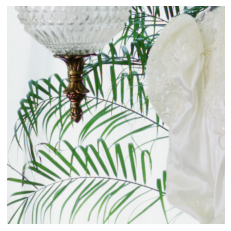

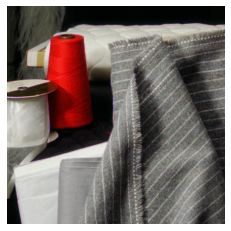

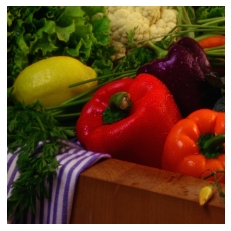

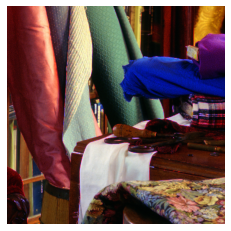

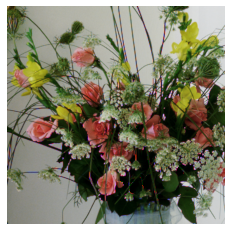

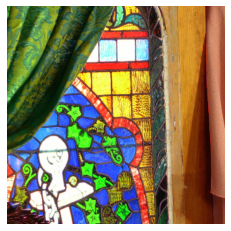

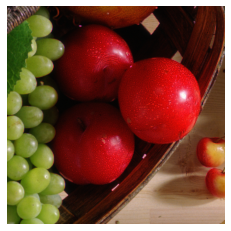

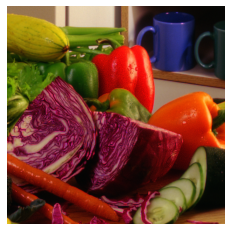

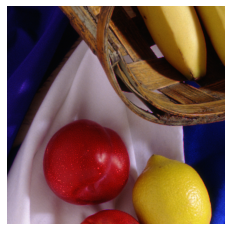

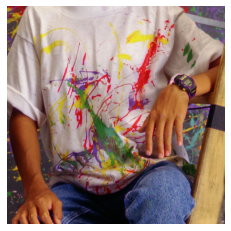

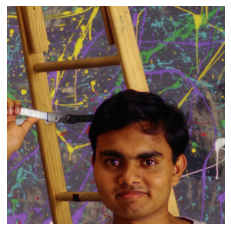

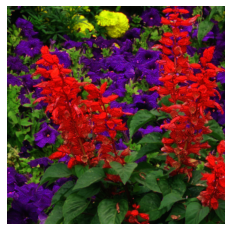

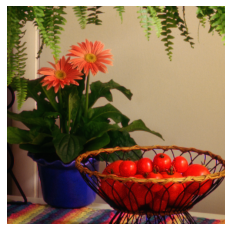

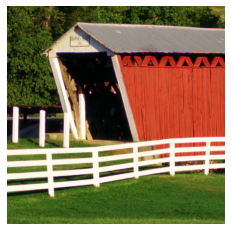

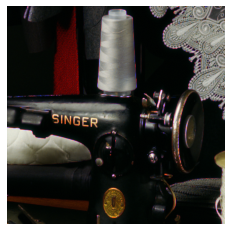

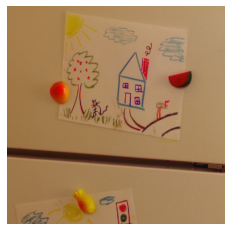

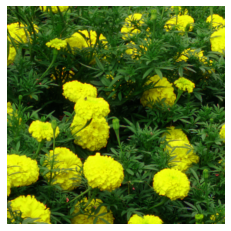

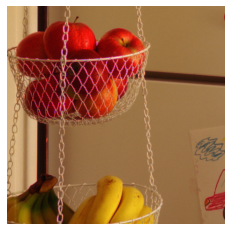

In [42]:
# process inputs

# path = "/Users/qiaowenyang/Desktop/22ss/jssxx/labs/Codingproject/code/inputs"
path = "/home/brighterw/PHOT22spr/coding_pj/input"

def process(path):
    for file in os.listdir(path):
        filename = os.path.join(path, file)
        img = imread(filename)
        img_cfa = img[:, :, 0] + img[:, :, 1] + img[:, :, 2]
        img_d = Weighted_Linear_Demosaicing(img_cfa)
        print(f"{file} after demosaicing:")
        plt.figure()
        plt.imshow(img_d)
        plt.axis('off')
        plt.savefig(f"weighted_linear_outputs/demosaicing_{file}", dpi=200)

process(path)